# Курсовой проект

## Описание проекта
**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

## Загрузка необходимых библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC

import xgboost as xgb, lightgbm as lgbm, catboost as catb
from catboost import Pool, cv

import warnings
warnings.simplefilter('ignore')

In [2]:
def fill_col(col):
    '''Fill the gaps by the median value.'''
    train[col].fillna(train[col].median(), inplace=True)

In [3]:
def fill_col_test(col):
    '''Fill the gaps by the median value from Train.'''
    test[col].fillna(train[col].median(), inplace=True)

In [4]:
# title_dict = {'fontsize': 20, 'fontweight': 'bold', 'family': 'Sans'}
# label_dict = {'fontsize': '14', 'family': 'Sans'}

## Обзор данных<a class="anchor" id="course_project_review"></a>
**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Пути к директориям и файлам

In [5]:
# input
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

#### Загрузка данных

In [6]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [8]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [10]:
test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


### Анализ признаков с пропусками

In [11]:
len(train) - train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [12]:
len(test) - test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

#### Пропуски в числовых признаках

In [17]:
def feature_corr_plot(df, feature):
    plt.figure(figsize=(8, 6))
    sns.barplot(x=df.corr().loc[feature].sort_values(ascending=False).values, 
                y=df.corr().loc[feature].sort_values(ascending=False).index)
    plt.title(f'Correlation with {feature}')

Заполним пропуски признака "Months since last delinquent" нулями

In [18]:
train['Months since last delinquent'].fillna(0, inplace=True)
test['Months since last delinquent'].fillna(0, inplace=True)

Признаки "Annual Income" иимеют много пропусков. Заполним пропуски

In [19]:
train.loc[train['Annual Income'].isnull(), :].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,0.0,1557.000000,1557.000000,1557.000000,1.557000e+03,1557.000000,1557.000000,1555.000000,1557.000000,1.557000e+03,1557.000000,0.0,1557.000000
mean,NaN,0.033398,11.151574,18.336737,1.489092e+06,0.171484,15.170841,0.113826,300744.253051,2.860604e+05,18451.107900,NaN,0.339756
std,NaN,0.280313,4.935590,7.038592,3.305621e+07,0.500137,22.400430,0.327673,179179.260062,3.048984e+05,12084.036473,NaN,0.473778
min,NaN,0.000000,2.000000,4.300000,0.000000e+00,0.000000,0.000000,0.000000,21472.000000,0.000000e+00,0.000000,NaN,0.000000
25%,NaN,0.000000,8.000000,13.500000,2.832280e+05,0.000000,0.000000,0.000000,167684.000000,1.140760e+05,10071.000000,NaN,0.000000
50%,NaN,0.000000,10.000000,17.300000,4.862660e+05,0.000000,0.000000,0.000000,262856.000000,2.058650e+05,16048.000000,NaN,0.000000
75%,NaN,0.000000,14.000000,21.900000,7.942660e+05,0.000000,28.000000,0.000000,404096.000000,3.572190e+05,23883.000000,NaN,1.000000
max,NaN,4.000000,33.000000,51.900000,1.304726e+09,5.000000,83.000000,2.000000,788942.000000,3.944514e+06,96177.000000,NaN,1.000000


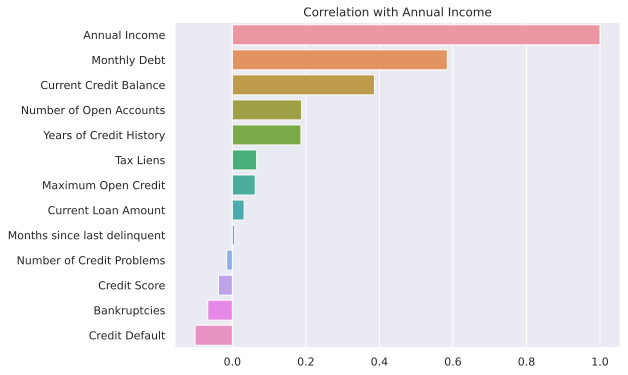

In [20]:
feature_corr_plot(train, 'Annual Income')

Самая высокая корреляция с признаками 'Monthly Debt' и 'Current Credit Balance'. Попробуем рассчитать недостающие значение 'Annual Income' следующим образом:
 - вычислим коэффициент, как отношение среднего 'Annual Income' к 'Monthly Debt'
 - вычислим 'Annual Income' как произведение коэффициента на значение 'Monthly Debt'

In [21]:
notnull_annual_income = train.loc[train['Annual Income'].notnull(), :]
coeff_1 = notnull_annual_income['Annual Income'].mean() / notnull_annual_income['Monthly Debt'].mean()
train['Annual Income'].fillna(train['Monthly Debt'] * coeff_1, inplace=True)
test['Annual Income'].fillna(test['Monthly Debt'] * coeff_1, inplace=True)

In [24]:
train['Credit Score']

0        749.0
1        737.0
2        742.0
3        694.0
4        719.0
         ...  
7495     697.0
7496    7410.0
7497     748.0
7498       NaN
7499       NaN
Name: Credit Score, Length: 7500, dtype: float64

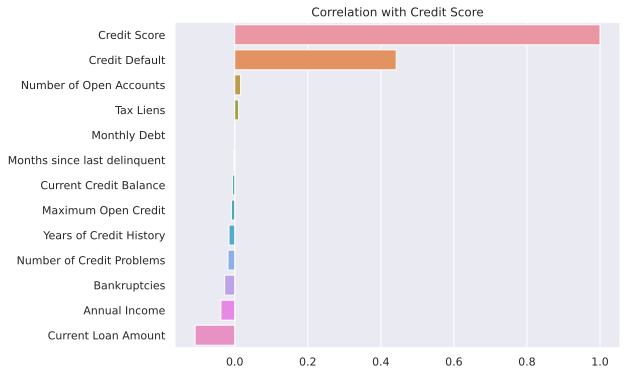

In [25]:
feature_corr_plot(train, 'Credit Score')

Самая высокая корреляция с целевым признаком 'Credit Default'.

In [27]:
train['Credit Score'].fillna(3000, inplace=True)
test['Credit Score'].fillna(3000, inplace=True)

In [28]:
fill_col('Bankruptcies')
fill_col_test('Bankruptcies')

#### Пропуски в нечисловых признаках

In [29]:
def fill_nom_col(col):   
    '''Fill the gaps with the mode'''
    train[col].fillna(train[col].mode().iloc[0], inplace=True)

In [30]:
def fill_nom_col_test(col):  
    '''Fill the gaps with the mode estimated on Train'''
    test[col].fillna(train[col].mode().iloc[0], inplace=True)

In [31]:
fill_nom_col('Years in current job')
fill_nom_col_test('Years in current job')

### Обзор данных

In [36]:
def correl_matrix(df):
    plt.figure(figsize = (10, 10))

    sns.set(font_scale=0.8)
    sns.heatmap(df[:].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

    plt.title('Матрица корреляции всех признаков')
    plt.show()

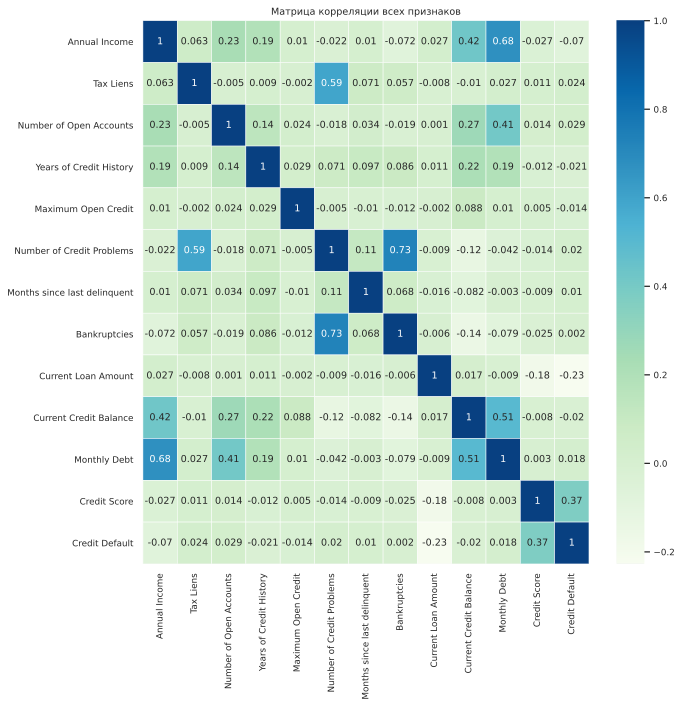

In [37]:
correl_matrix(train)

### Обзор целевого признака

In [38]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [39]:
target = 'Credit Default'

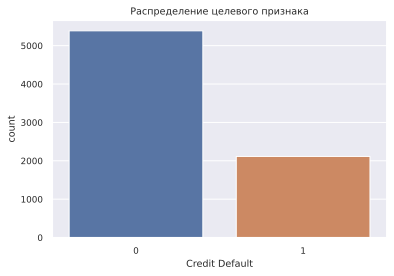

In [41]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target, data=train)
plt.title('Распределение целевого признака');

Данные несбалансированы

### Обработка числовых признаков

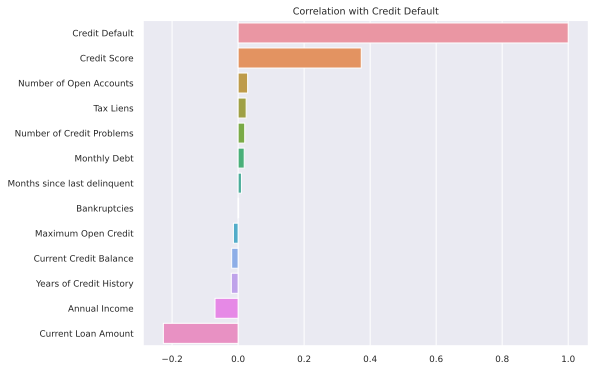

In [44]:
feature_corr_plot(train, target)

In [78]:
def feat_plot(col):        
    fig, ax = plt.subplots(nrows=1, ncols=4)
    ax1, ax2, ax3, ax4 = ax.flatten()
    
    default = train.loc[train ['Credit Default'] == 1, col]
    not_default = train.loc[train ['Credit Default'] == 0, col]
    ax1.hist((default, not_default), 
             bins=20, 
             histtype='stepfilled', 
             alpha=0.5, 
             color=('yellow', 'red'), 
             density=True, 
             label=('Credit Default = 1', 'Credit Default = 0'))
    ax1.legend(loc='upper right', frameon=True)
    ax1.set_title(col)
     
   # Сравнение с тестовым датасетом.
    ax2.hist(test[col], bins=20)
    ax2.set_title(f'Test {col}')
    
    
    ax3.boxplot(train[col])
    ax4.set_title(col)
    
    ax4.boxplot(test[col])
    ax4.set_title(f'Test {col}')
    
    fig.set_size_inches(12, 4)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)    

In [88]:
def change_col(df, col):
    # Устранение выбросов <1 и >99 квантилей
    max_ = train[col].quantile(.99)
    min_ = train[col].quantile(.01)
    df.loc[train[col] > df[col].quantile(.99), col] = max_
    df.loc[train[col] < df[col].quantile(.01), col] = min_

#### Признак 'Annual Income'

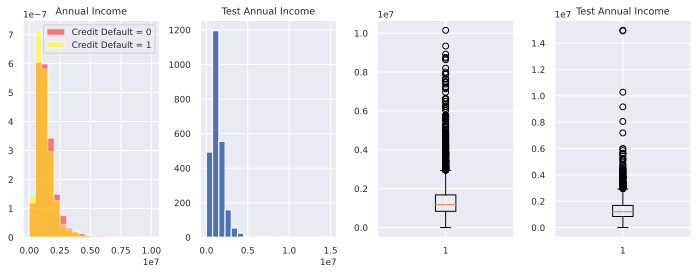

In [81]:
feat_plot('Annual Income')

#### Признак 'Tax Liens'

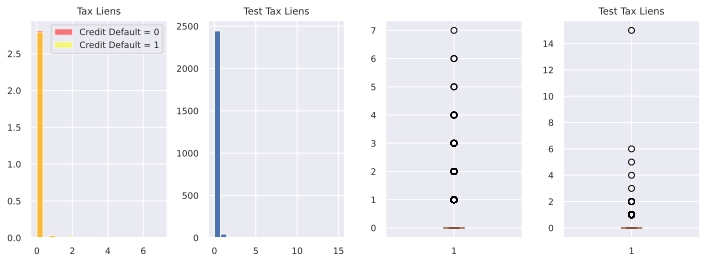

In [82]:
feat_plot('Tax Liens')

Предположим, что признак "Tax Liens" категориальный

In [84]:
train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Преобразуем признак 'Tax Liens' в категориальный: 0 - отсутствие обременений, 1 - наличие обременений.

In [86]:
train.loc[train['Tax Liens'] > 0, 'Tax Liens'] = 1
train['Tax Liens'] = train['Tax Liens'].astype('int')
test.loc[test['Tax Liens'] > 0, 'Tax Liens'] = 1
test['Tax Liens'] = test['Tax Liens'].astype('int')

#### Признак 'Number of Open Accounts'

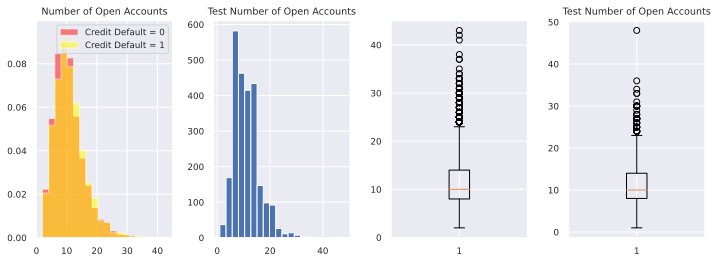

In [87]:
feat_plot('Number of Open Accounts')

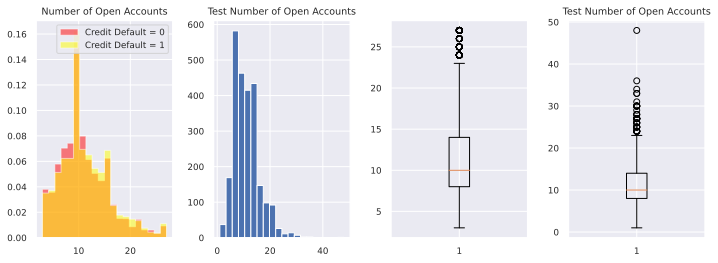

In [89]:
change_col(train, 'Number of Open Accounts')
change_col(test, 'Number of Open Accounts')
feat_plot('Number of Open Accounts')

**Years of Credit History**

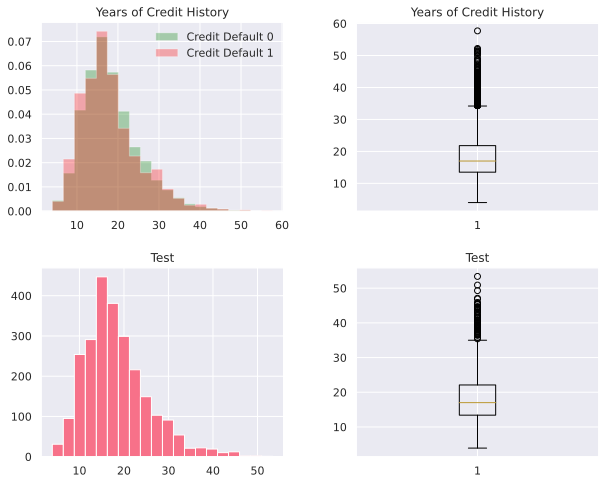

In [45]:
feat_plot('Years of Credit History')

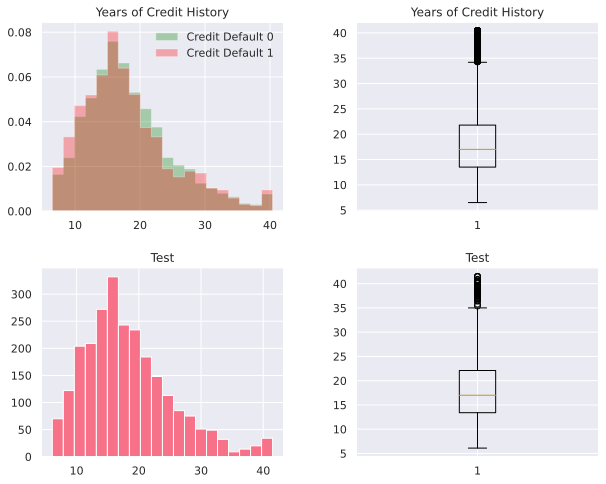

In [46]:
change_col('Years of Credit History')
change_col_test('Years of Credit History')
feat_plot('Years of Credit History')

**Maximum Open Credit**

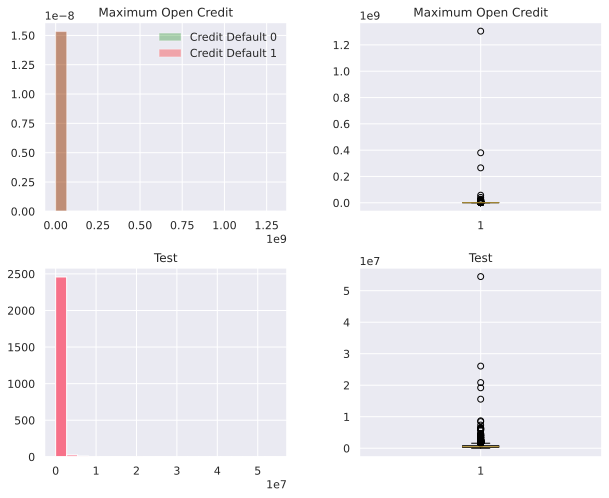

In [47]:
feat_plot('Maximum Open Credit')

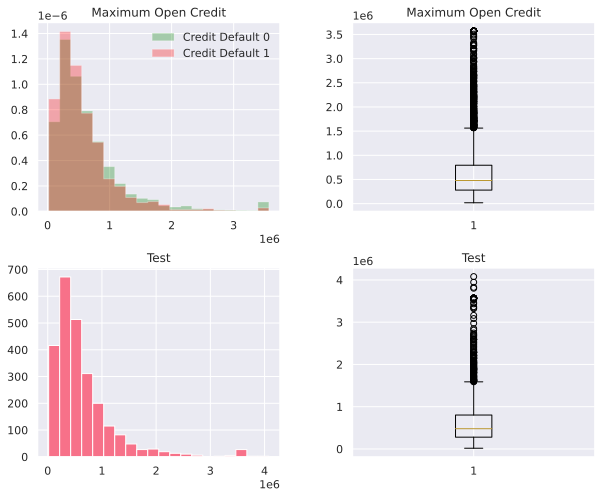

In [48]:
change_col('Maximum Open Credit')
change_col_test('Maximum Open Credit')
feat_plot('Maximum Open Credit')

**Number of Credit Problems**

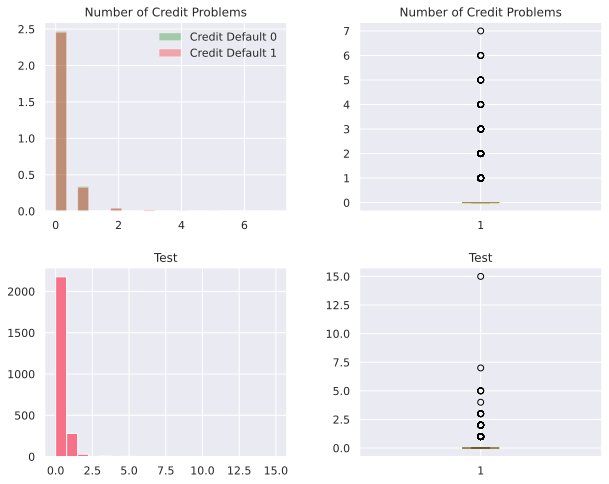

In [49]:
feat_plot('Number of Credit Problems')

"Number of Credit Problems" is a categorical feature.

In [50]:
train['Number of Credit Problems'].unique()

array([1., 0., 3., 2., 6., 4., 5., 7.])

Assign lable 0 to those who had no problems with credit, and 1-to those who had.

In [51]:
train.loc[train['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
train['Number of Credit Problems'] = train['Number of Credit Problems'].astype('int')

Let's repeat that for the testing dataset.

In [52]:
test.loc[test['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
test['Number of Credit Problems'] = test['Number of Credit Problems'].astype('int')

**Months since last delinquent**

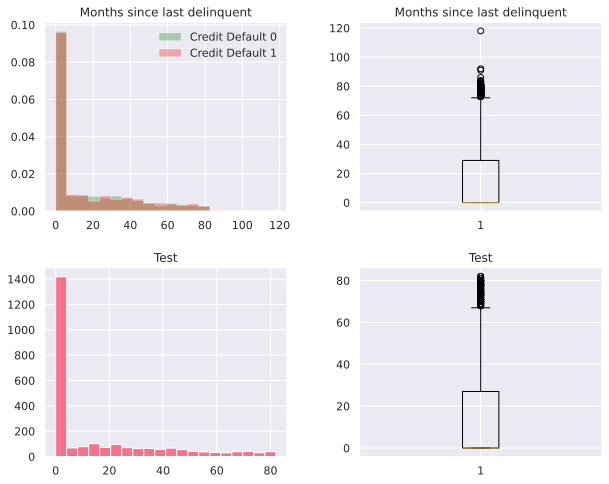

In [53]:
feat_plot('Months since last delinquent')

This makes sense to bring the feature "Months since last delinquent" to bynare type. 1 - the delay happened, 0 - it did not.

In [54]:
train.loc[train['Months since last delinquent'] > 0, 'Months since last delinquent'] = 1
train['Months since last delinquent'] = train['Months since last delinquent'].astype('int')

In [55]:
test.loc[test['Months since last delinquent'] > 0, 'Months since last delinquent'] = 1
test['Months since last delinquent'] = test['Months since last delinquent'].astype('int')

**Bankruptcies**

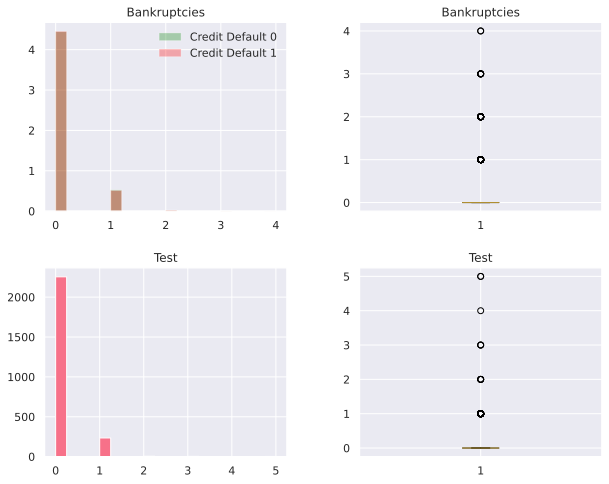

In [56]:
feat_plot('Bankruptcies')

A categorical feature again.

In [57]:
train['Bankruptcies'].unique()

array([1., 0., 3., 2., 4.])

We will assign the lable 0 to those who did not have bankruptcies, and 1 to all others.

In [58]:
train.loc[train['Bankruptcies'] > 0, 'Bankruptcies'] = 1
train['Bankruptcies'] = train['Bankruptcies'].astype('int')

In [59]:
test.loc[test['Bankruptcies'] > 0, 'Bankruptcies'] = 1
test['Bankruptcies'] = test['Bankruptcies'].astype('int')

**Current Loan Amount**

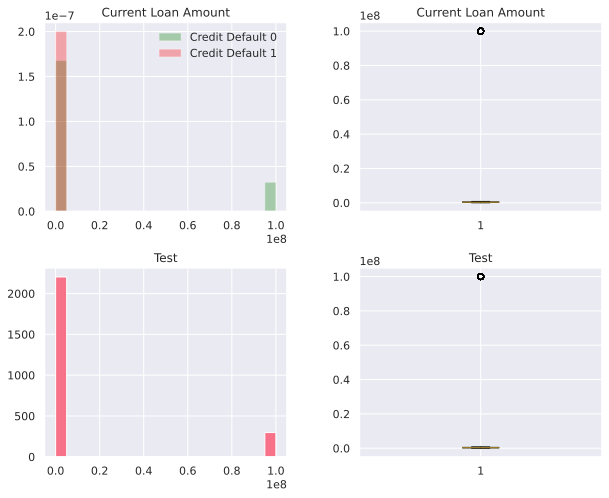

In [60]:
feat_plot('Current Loan Amount')

In [61]:
train.loc[train['Current Loan Amount'] == 99999999.0].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,8.700000e+02,870.000000,870.000000,870.000000,8.700000e+02,870.000000,870.000000,870.000000,870.0,8.700000e+02,870.000000,870.000000,870.0
mean,1.427779e+06,0.014943,11.108046,18.491615,6.879436e+05,0.134483,0.422989,0.105747,99999999.0,3.028599e+05,17933.028736,730.225287,0.0
std,8.998839e+05,0.121393,4.689170,6.890013,6.101708e+05,0.341367,0.494318,0.307691,0.0,3.590877e+05,12264.380264,21.395230,0.0
min,2.167140e+05,0.000000,3.000000,6.500000,1.726978e+04,0.000000,0.000000,0.000000,99999999.0,0.000000e+00,0.000000,601.000000,0.0
25%,8.668560e+05,0.000000,8.000000,13.725000,3.001625e+05,0.000000,0.000000,0.000000,99999999.0,1.145225e+05,9484.750000,726.000000,0.0
50%,1.245507e+06,0.000000,10.000000,17.200000,5.155040e+05,0.000000,0.000000,0.000000,99999999.0,2.134650e+05,15445.500000,737.000000,0.0
75%,1.726886e+06,0.000000,14.000000,22.350000,8.601725e+05,0.000000,1.000000,0.000000,99999999.0,3.633702e+05,23421.250000,744.000000,0.0
max,8.758449e+06,1.000000,27.000000,40.401000,3.568459e+06,1.000000,1.000000,1.000000,99999999.0,4.249673e+06,94674.000000,751.000000,0.0


We see that the target variable in these lines is 0 and the "Credit score" value is close to the average, 730. Let's allocate these lines in a separate class.

In [62]:
train['Loan Amount Cat'] = 1
train.loc[train['Current Loan Amount'] == 99999999.0, 'Loan Amount Cat'] = 0

In [63]:
test['Loan Amount Cat'] = 1
test.loc[test['Current Loan Amount'] == 99999999.0, 'Loan Amount Cat'] = 0

**Current Credit Balance**

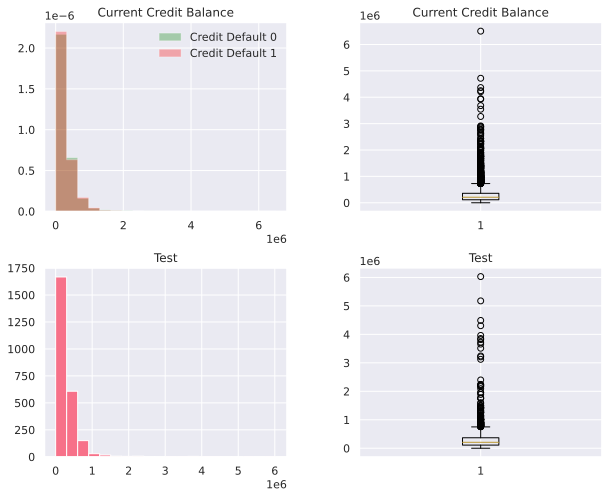

In [64]:
feat_plot('Current Credit Balance')

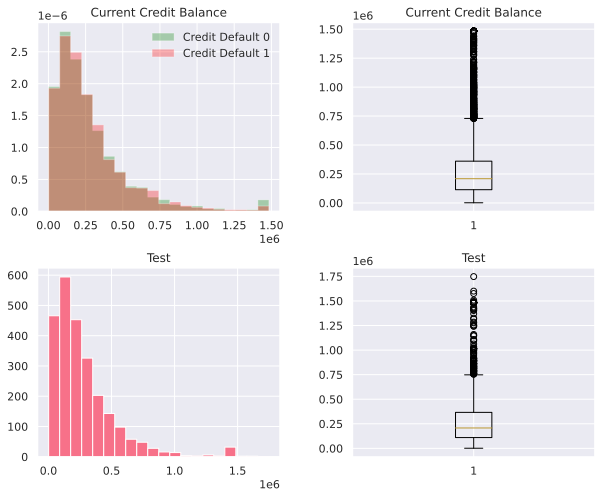

In [65]:
change_col('Current Credit Balance')
change_col_test('Current Credit Balance')
feat_plot('Current Credit Balance')

**Monthly Debt**

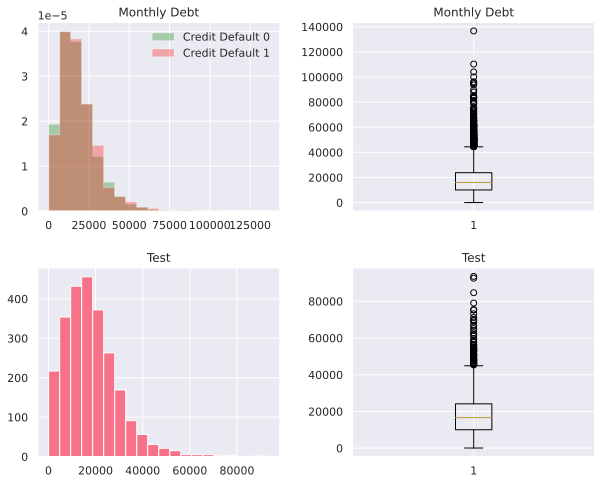

In [66]:
feat_plot('Monthly Debt')

In [67]:
# change_col('Monthly Debt')
# change_col_test('Monthly Debt')
# feat_plot('Monthly Debt')

**Credit Score**

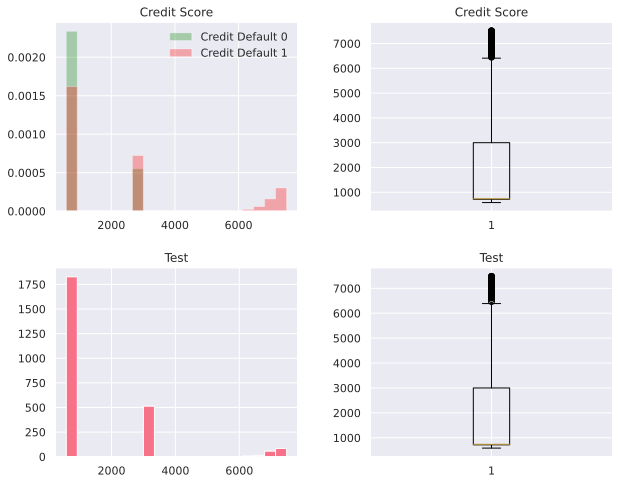

In [68]:
feat_plot('Credit Score')

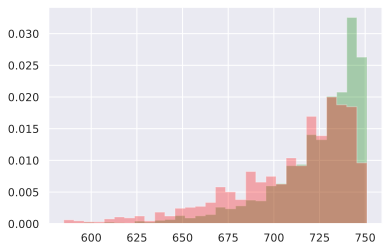

In [69]:
default = train.loc[
        (train ['Credit Default'] == 1) & (train['Credit Score'] < 800), 'Credit Score'
]
not_default = train.loc[
        (train ['Credit Default'] == 0) & (train['Credit Score'] < 800), 'Credit Score'
]
plt.hist((default, not_default), 
         bins=30, 
         histtype='stepfilled', 
         alpha=0.3, 
         color=('red', 'green'), 
         density=True, 
         label=('Credit Default 1', 'Credit Default 0')
);

In [70]:
train['Credit Score Cat'] = 0
train.loc[(train['Credit Score'] > 800), 'Credit Score Cat'] = 1
train.loc[(train['Credit Score'] == 3000), 'Credit Score Cat'] = 2
train.loc[(train['Credit Score'] < 735), 'Credit Score Cat'] = 2
train['Credit Score Cat'].astype('str')

0       0
1       0
2       0
3       2
4       2
       ..
7495    2
7496    1
7497    0
7498    2
7499    2
Name: Credit Score Cat, Length: 7500, dtype: object

In [71]:
test['Credit Score Cat'] = 0
test.loc[(test['Credit Score'] > 800), 'Credit Score Cat'] = 1
test.loc[(test['Credit Score'] == 3000), 'Credit Score Cat'] = 2
test.loc[(test['Credit Score'] < 735), 'Credit Score Cat'] = 2
test['Credit Score Cat'].astype('str')

0       2
1       2
2       1
3       0
4       2
       ..
2495    0
2496    2
2497    2
2498    0
2499    1
Name: Credit Score Cat, Length: 2500, dtype: object

**Overview of categorical features**

In [72]:
for cat_colname in train.select_dtypes(include='object').columns:
    print(str(cat_colname) + 
          '\n\n' + 
          str(train[cat_colname].value_counts()) + 
          '\n' + 
          '*' * 79 + 
          '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
*******************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
*******************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy       

In [73]:
def countplot(feature):
    '''Feature values grouped by the target variable.'''
    plt.figure(figsize=(10, 6))
    sns.countplot(y=feature, hue=target, data=train)
    plt.legend(title='Target', loc='lower right')

**Home Ownership**

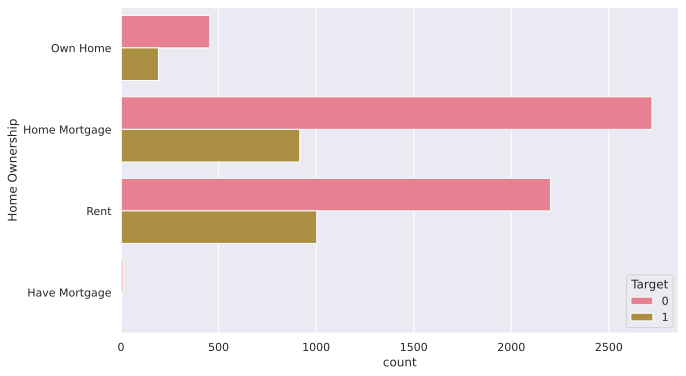

In [74]:
countplot("Home Ownership")

In [75]:
train.loc[train["Home Ownership"] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'
test.loc[test["Home Ownership"] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'

**Years in current job**

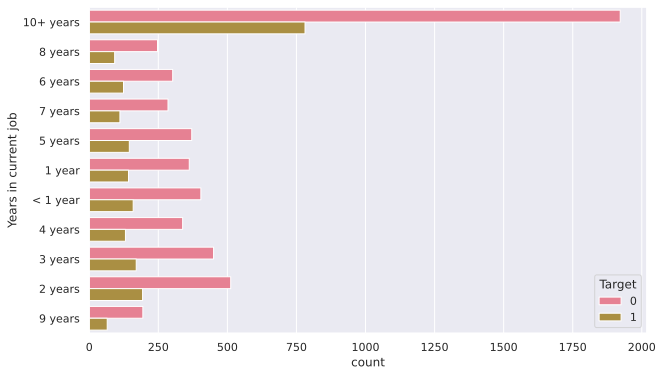

In [76]:
countplot("Years in current job")

In [77]:
train["Years in current job"].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [78]:
replace_dict = {'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5,
                '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10+ years':10}

train['Years in current job'].replace(replace_dict, inplace=True)
test['Years in current job'].replace(replace_dict, inplace=True)

**Purpose**

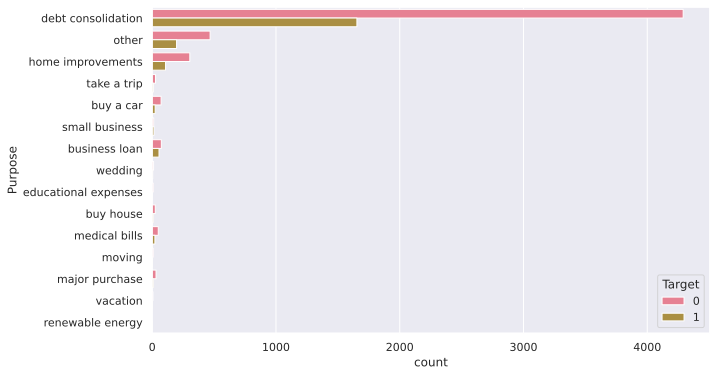

In [79]:
countplot("Purpose")

Let's reduce the number of categories. Let's join the categories "business loan" and "small business", they have a large share of loan default. Let's also join small categories.

In [80]:
train.loc[train['Purpose'] == 'small business', 'Purpose'] = 'business loan'
train.loc[train['Purpose'] == 'buy a car', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'medical bills', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'take a trip', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'buy house', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'wedding', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'moving', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'educational expenses', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'vacation', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'renewable energy', 'Purpose'] = 'major purchase'

In [81]:
train['Purpose'].value_counts()

debt consolidation    5944
other                  665
home improvements      412
major purchase         324
business loan          155
Name: Purpose, dtype: int64

In [82]:
test.loc[test['Purpose'] == 'small business', 'Purpose'] = 'business loan'
test.loc[test['Purpose'] == 'buy a car', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'medical bills', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'take a trip', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'buy house', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'wedding', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'moving', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'educational expenses', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'vacation', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'renewable energy', 'Purpose'] = 'major purchase'

**Term**

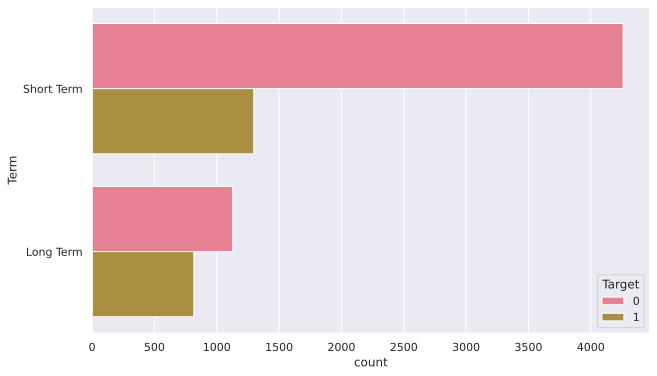

In [83]:
countplot("Term")

Let's transform this feature, let the Short Term be 0, and the Long Term-1.

In [84]:
train.loc[train['Term'] == 'Long Term', 'Term'] = 1
train.loc[train['Term'] == 'Short Term', 'Term'] = 0
train['Term'] = train['Term'].astype('int')

In [85]:
test.loc[test['Term'] == 'Long Term', 'Term'] = 1
test.loc[test['Term'] == 'Short Term', 'Term'] = 0
test['Term'] = test['Term'].astype('int')

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int64  
 3   Tax Liens                     7500 non-null   int64  
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   int64  
 8   Months since last delinquent  7500 non-null   int64  
 9   Bankruptcies                  7500 non-null   int64  
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Feature selection

In [89]:
# basic_features = train.columns.drop(target).drop('Id').tolist()
basic_features = train.columns.drop(target).tolist()
basic_features

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Loan Amount Cat',
 'Credit Score Cat']

In [90]:
numeric_features = train.select_dtypes(
                    include='float').columns.tolist()
numeric_features

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [91]:
category_features = train.select_dtypes(
                    include=('object')).columns.tolist()
category_features

['Home Ownership', 'Purpose']

In [92]:
selected_features = basic_features
selected_features

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Loan Amount Cat',
 'Credit Score Cat']

Since we don't need dummies for CatBoost, it's better to save the datasets and feature lists.

In [93]:
CAT_DATASET_PATH = 'for_cat.csv'
train.to_csv(CAT_DATASET_PATH, index=False, encoding='utf-8')

CAT_TEST_DATASET_PATH = 'for_cat_test.csv'
test.to_csv(CAT_TEST_DATASET_PATH, index=False, encoding='utf-8')

**Dummies**

In [94]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

#### New feature lists

In [96]:
# basic_feats = train.columns.drop(target).drop('Id').tolist()
basic_feats = train.columns.drop(target).tolist()

In [97]:
numeric_feats = train.select_dtypes(include='float').columns.tolist()

In [98]:
category_feats = train.select_dtypes(include=('uint8')).columns.tolist()

In [99]:
selected_feats = basic_feats

Let's look again at the correlation of features with the target variable.

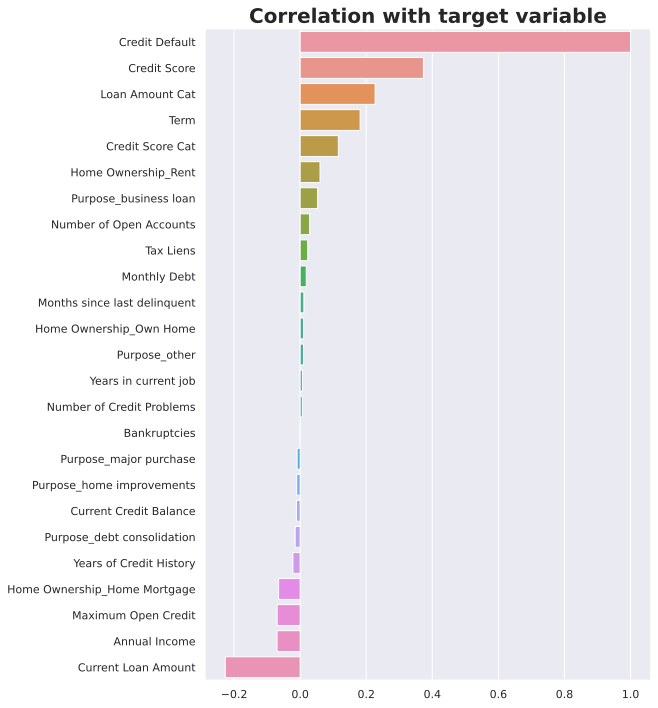

In [100]:
corr_with_target = train[selected_feats + 
                         [target]].corr().loc[target].sort_values(ascending=False)
plt.figure(figsize=(8, 12))
sns.barplot(x=corr_with_target.values, 
            y=corr_with_target.index)
plt.title('Correlation with target variable', 
          fontdict=title_dict);

### Data normalization, splitting into train and test, and balancing target variable classes

In [101]:
def norm_data(train, test, features, scaler):
    '''Normalize the data'''
    train_norm = train.copy()
    train_norm[features] = scaler.fit_transform(train_norm[features])
    test_norm = test.copy()
    test_norm[features] = scaler.transform(test_norm[features])
    return train_norm, test_norm

In [102]:
# MinMaxScaler
train_norm, test_norm = norm_data(
    train, test, 
    numeric_feats, 
    MinMaxScaler()
)

In [103]:
# StandardScaler
train_standard, test_standard = norm_data(
    train, test, 
    numeric_feats, 
    StandardScaler()
)

In [104]:
def balance_df_by_target(df, target_name):
    '''Return balanced on Target dataset'''
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / 
                           target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(
                                target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [105]:
def split_and_balance_df(train_norm, selected_feats, test_size):
    '''Split train_norm to X_train, y_train and balance X_train'''
    X = train_norm[selected_feats]
    y = train_norm[target]
    X_train, X_test, y_train, y_test = train_test_split(
                X, y, shuffle=True, test_size=test_size, random_state=42)
    df_for_balancing = pd.concat([X_train, y_train], axis=1)
    df_balanced = balance_df_by_target(df_for_balancing, target)
    X_train = df_balanced.drop(columns=target)
    y_train = df_balanced[target]
    return X_train, X_test, y_train, y_test

In [106]:
X_train, X_test, y_train, y_test = split_and_balance_df(
        train_norm, selected_feats, test_size=0.25
)

In [107]:
X_train_s, X_test_s, y_train_s, y_test_s = split_and_balance_df(
        train_standard, selected_feats, test_size=0.25
)

### Basic models building and evaluation

In [108]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    '''Print the report'''
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [109]:
def model(model, X_train, y_train, X_test, y_test, features):
    '''Return model'''
    model.fit(X_train[features], y_train) 
    y_train_pred = model.predict(X_train[features])
    y_test_pred = model.predict(X_test[features])
    print(get_classification_report(y_train, y_train_pred, y_test, y_test_pred))
    return model

## LogisticRegression

In [104]:
# LogisticRegression & MinMaxScaler
model_lr = model(
            LogisticRegression(), 
            X_train, y_train, X_test, y_test, 
            features=selected_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      4074
           1       0.66      0.58      0.61      3102

   micro avg       0.69      0.69      0.69      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.68      0.69      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1313
           1       0.51      0.59      0.55       562

   micro avg       0.71      0.71      0.71      1875
   macro avg       0.66      0.67      0.66      1875
weighted avg       0.72      0.71      0.71      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               991  322
1               229  333
None


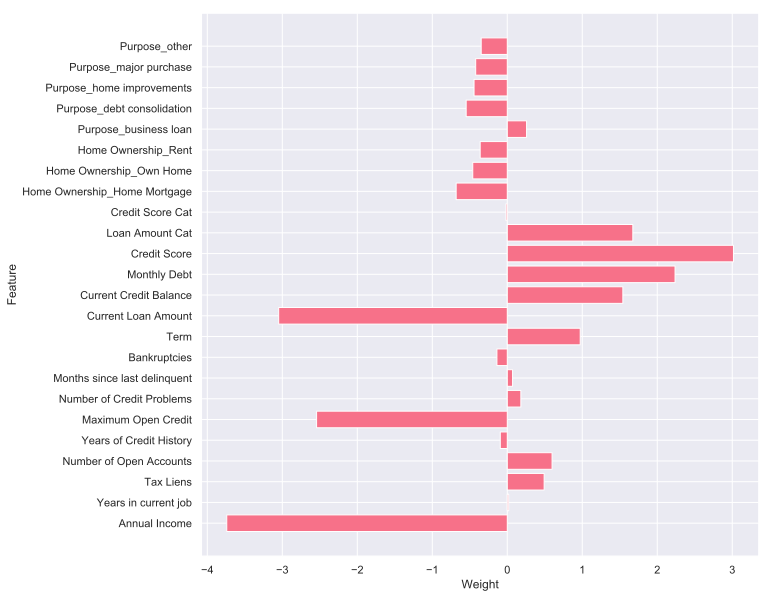

In [105]:
# The features and their weights
plt.rcParams['figure.figsize'] = 10, 10
plt.barh(selected_feats, model_lr.coef_.flatten())

plt.xlabel("Weight")
plt.ylabel("Feature")

plt.show()

In [106]:
# Drop the less weighted features
selected_feats = np.array(selected_feats)
coefs = dict(zip(selected_feats, model_lr.coef_.flatten()))
new_feats = []
for feat, coef in coefs.items():
    if abs(coef) > 0.25:
        new_feats.append(feat)
new_feats

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Maximum Open Credit',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Loan Amount Cat',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_other']

In [107]:
# LogisticRegression & MinMaxScaler & most important features
model_lr_new_feats = model(
                    LogisticRegression(), 
                    X_train, y_train, X_test, y_test, 
                    features=new_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      4074
           1       0.65      0.58      0.61      3102

   micro avg       0.68      0.68      0.68      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.68      0.68      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1313
           1       0.51      0.60      0.55       562

   micro avg       0.70      0.70      0.70      1875
   macro avg       0.66      0.67      0.66      1875
weighted avg       0.72      0.70      0.71      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               984  329
1               226  336
None


In [108]:
# LogisticRegression & StandardScaler
model_lr_s = model(
            LogisticRegression(), 
            X_train_s, y_train_s, X_test_s, y_test_s, 
            features=selected_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      4074
           1       0.66      0.58      0.62      3102

   micro avg       0.69      0.69      0.69      7176
   macro avg       0.68      0.67      0.68      7176
weighted avg       0.69      0.69      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1313
           1       0.51      0.59      0.55       562

   micro avg       0.71      0.71      0.71      1875
   macro avg       0.66      0.67      0.66      1875
weighted avg       0.72      0.71      0.71      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               990  323
1               230  332
None


In [109]:
# LogisticRegression & StandardScaler & most important features
model_lr_s = model(
            LogisticRegression(),
            X_train_s, y_train_s, X_test_s, y_test_s, 
            features=new_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.77      0.73      4074
           1       0.65      0.58      0.61      3102

   micro avg       0.68      0.68      0.68      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.68      0.68      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1313
           1       0.51      0.60      0.55       562

   micro avg       0.70      0.70      0.70      1875
   macro avg       0.66      0.68      0.67      1875
weighted avg       0.72      0.70      0.71      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               982  331
1               223  339
None


In [110]:
# test_norm['Credit Default'] = model_lr_new_feats.predict(
#     test_norm[new_feats])
# PRED_PATH = 'ATaganova_predictions.csv'
# test_norm.loc[:, ['Id', 'Credit Default']].to_csv(
#     PRED_PATH, index=False, encoding='utf-8')

The result of the model on kaggle.com

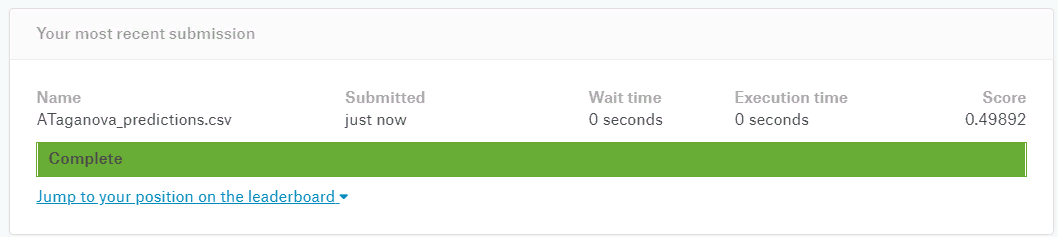

## RidgeClassifier

In [111]:
model_ridge = model(
            RidgeClassifier(), 
            X_train, y_train, X_test, y_test, 
            features=selected_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      4074
           1       0.66      0.55      0.60      3102

   micro avg       0.69      0.69      0.69      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.68      0.69      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1313
           1       0.52      0.58      0.55       562

   micro avg       0.72      0.72      0.72      1875
   macro avg       0.67      0.68      0.67      1875
weighted avg       0.72      0.72      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1017  296
1                237  325
None


In [112]:
from sklearn.linear_model import RidgeClassifierCV

In [113]:
model_ridgeCV = model(
            RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100, 300]), 
            X_train, y_train, X_test, y_test, 
            features=selected_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      4074
           1       0.67      0.56      0.61      3102

   micro avg       0.69      0.69      0.69      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.69      0.69      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1313
           1       0.53      0.58      0.55       562

   micro avg       0.72      0.72      0.72      1875
   macro avg       0.67      0.68      0.67      1875
weighted avg       0.73      0.72      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1025  288
1                238  324
None


## XGBoost

In [114]:
# XGBoost & MinMaxScaler
model_xgb = model(xgb.XGBClassifier(random_state=42),
                  X_train, y_train, X_test, y_test, 
                  features=selected_feats)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      4074
           1       0.79      0.57      0.66      3102

   micro avg       0.75      0.75      0.75      7176
   macro avg       0.76      0.72      0.73      7176
weighted avg       0.75      0.75      0.74      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1313
           1       0.57      0.47      0.52       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1114  199
1                298  264
None


In [115]:
# XGBoost & StandardScaler
model_xgb_s = model(xgb.XGBClassifier(random_state=42), 
                    X_train_s, y_train_s, X_test_s, y_test_s, 
                    features=selected_feats)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      4074
           1       0.79      0.57      0.66      3102

   micro avg       0.75      0.75      0.75      7176
   macro avg       0.76      0.72      0.73      7176
weighted avg       0.75      0.75      0.74      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1313
           1       0.57      0.47      0.52       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1114  199
1                298  264
None


In [116]:
# test_norm['Credit Default'] = model_xgb.predict(test_norm[selected_feats])
# PRED_PATH = 'ATaganova_predictions.csv'
# test_norm.loc[:, ['Id', 'Credit Default']].to_csv(
#     PRED_PATH, index=False, encoding='utf-8')

## LightGBM

In [117]:
# LightGBM & MinMaxScaler
model_lgbm = model(lgbm.LGBMClassifier(random_state=42, reg_lambda=300),
                  X_train, y_train, X_test, y_test, 
                  features=selected_feats)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      4074
           1       0.77      0.62      0.68      3102

   micro avg       0.75      0.75      0.75      7176
   macro avg       0.76      0.74      0.74      7176
weighted avg       0.76      0.75      0.75      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1313
           1       0.56      0.52      0.54       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1082  231
1                271  291
None


In [121]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    '''Return the list of the most important features'''
    feature_importances = pd.DataFrame(
            {'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values(
            'importance', ascending=False)
       
    plt.figure(figsize = (8, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

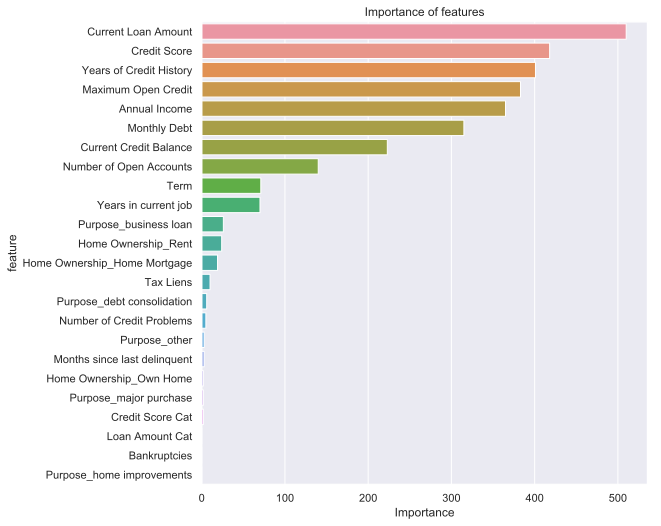

In [119]:
important_features_top = show_feature_importances(
        X_train.columns, 
        model_lgbm.feature_importances_, 
        get_top=15
)

In [120]:
# LightGBM & MinMaxScaler & important_features_top
model_lgbm_important_features_top = model(
                lgbm.LGBMClassifier(random_state=42, reg_alpha=7.0, reg_lambda=300.0),
                X_train, y_train, X_test, y_test, 
                features=important_features_top)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.86      0.79      4074
           1       0.76      0.59      0.67      3102

   micro avg       0.75      0.75      0.75      7176
   macro avg       0.75      0.73      0.73      7176
weighted avg       0.75      0.75      0.74      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1313
           1       0.55      0.51      0.53       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.67      0.67      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1083  230
1                277  285
None


In [121]:
# test_norm['Credit Default'] = model_lgbm_important_features_top.predict(test_norm[important_features_top])
# PRED_PATH = 'ATaganova_predictions.csv'
# test_norm.loc[:, ['Id', 'Credit Default']].to_csv(
#     PRED_PATH, index=False, encoding='utf-8')

The result of the model on kaggle.com

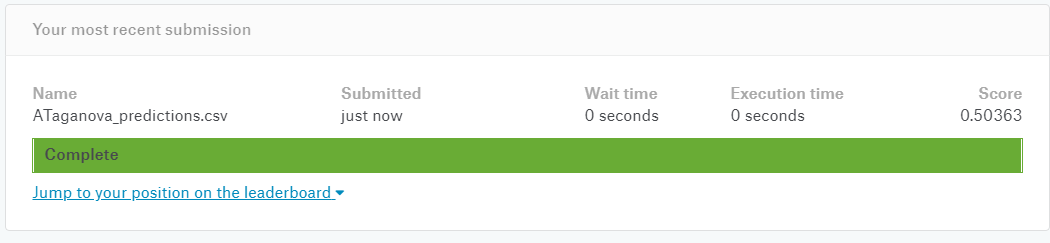

In [122]:
# LightGBM & StandardScaler
model_lgbm_s = model(lgbm.LGBMClassifier(random_state=42, reg_lambda=300),
                  X_train_s, y_train_s, X_test_s, y_test_s, 
                  features=selected_feats)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      4074
           1       0.77      0.61      0.68      3102

   micro avg       0.76      0.76      0.76      7176
   macro avg       0.76      0.74      0.74      7176
weighted avg       0.76      0.76      0.75      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1313
           1       0.56      0.51      0.53       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1089  224
1                275  287
None


## CatBoost

In [111]:
train = pd.read_csv(CAT_DATASET_PATH)
test = pd.read_csv(CAT_TEST_DATASET_PATH)

In [112]:
train_norm_cat, test_norm_cat = norm_data(
    train, test, numeric_features, MinMaxScaler())

In [113]:
train_norm_cat_s, test_norm_cat_s = norm_data(
    train, test, numeric_features, StandardScaler())

In [114]:
(X_cat_train_without_norm, X_cat_test_without_norm, 
         y_cat_train_without_norm, y_cat_test_without_norm) = split_and_balance_df(
    train, selected_features, test_size=0.25)

In [115]:
X_cat_train, X_cat_test, y_cat_train, y_cat_test = split_and_balance_df(
    train_norm_cat, selected_features, test_size=0.25)

In [116]:
X_cat_train_s, X_cat_test_s, y_cat_train_s, y_cat_test_s = split_and_balance_df(
    train_norm_cat_s, selected_features, test_size=0.25)

In [117]:
# CatBoost
model_catb_without_norm = model(catb.CatBoostClassifier
                   (cat_features=category_features, 
                     l2_leaf_reg=300, 
                     random_state=42, 
                     silent=True), 
                   X_cat_train_without_norm, y_cat_train_without_norm, 
                   X_cat_test_without_norm, y_cat_test_without_norm, 
                   features=selected_features)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      4074
           1       0.82      0.63      0.71      3102

    accuracy                           0.78      7176
   macro avg       0.79      0.76      0.77      7176
weighted avg       0.79      0.78      0.78      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1313
           1       0.57      0.50      0.53       562

    accuracy                           0.74      1875
   macro avg       0.69      0.67      0.68      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1105  208
1                282  280
None


In [118]:
# CatBoost & MinMaxScaler
model_catb = model(catb.CatBoostClassifier
                   (cat_features=category_features,
                    l2_leaf_reg=300,
                     random_state=42, 
                     silent=True), 
                   X_cat_train, y_cat_train, 
                   X_cat_test, y_cat_test, 
                   features=selected_features)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.89      0.82      4074
           1       0.82      0.64      0.72      3102

    accuracy                           0.78      7176
   macro avg       0.79      0.77      0.77      7176
weighted avg       0.79      0.78      0.78      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1313
           1       0.57      0.49      0.53       562

    accuracy                           0.73      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1101  212
1                286  276
None


In [119]:
# CatBoost & StandardScaler
model_catb_s = model(catb.CatBoostClassifier
                     (cat_features=category_features, 
                       l2_leaf_reg=300, 
                       random_state=42, 
                       silent=True), 
                     X_cat_train_s, y_cat_train_s, 
                     X_cat_test_s, y_cat_test_s, 
                     features=selected_features)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.89      0.82      4074
           1       0.82      0.64      0.72      3102

    accuracy                           0.78      7176
   macro avg       0.79      0.77      0.77      7176
weighted avg       0.79      0.78      0.78      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1313
           1       0.57      0.49      0.53       562

    accuracy                           0.74      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1106  207
1                287  275
None


Let's see what features were the most important, and see if the result will not improve, if we leave only these features.

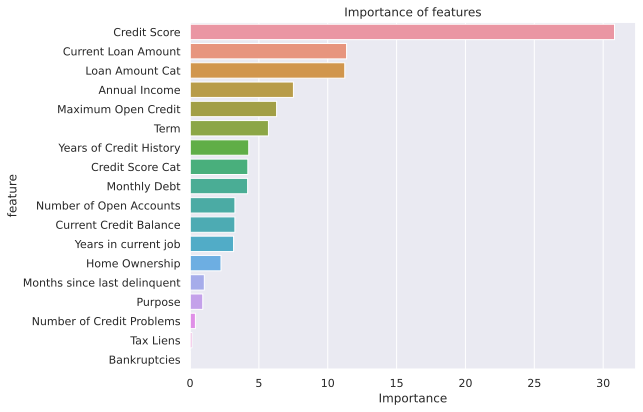

In [122]:
important_features_top = show_feature_importances(
                    X_cat_train_without_norm.columns, 
                    model_catb.feature_importances_, 
                    get_top=15
)

In [123]:
# CatBoost & important_features_top
model_catb_without_norm_important_features_top = model(
                        catb.CatBoostClassifier
                        (cat_features=category_features, 
                          l2_leaf_reg=300, 
                          random_state=42, 
                          silent=True), 
                        X_cat_train_without_norm, y_cat_train_without_norm, 
                        X_cat_test_without_norm, y_cat_test_without_norm, 
                        features=important_features_top)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.89      0.82      4074
           1       0.82      0.64      0.72      3102

    accuracy                           0.78      7176
   macro avg       0.79      0.77      0.77      7176
weighted avg       0.79      0.78      0.78      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1313
           1       0.56      0.50      0.53       562

    accuracy                           0.73      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1094  219
1                281  281
None


In [135]:
# # Prediction on Test
# test['Credit Default'] = model_catb_without_norm.predict(
#                         test[selected_features])
# test['Credit Default'] = test[
#                             'Credit Default'].astype('int')
# PRED_PATH = 'ATaganova_predictions.csv'
# test.loc[:, ['Id', 'Credit Default']].to_csv(
#     PRED_PATH, index=False, encoding='utf-8')

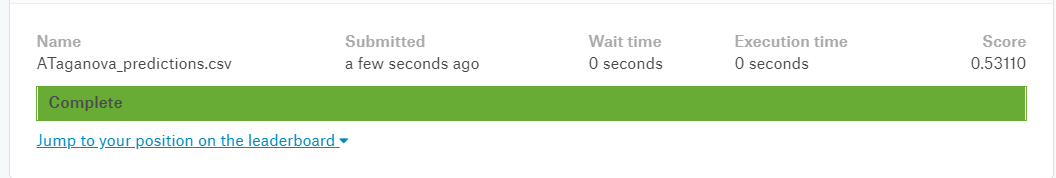

And that is the best score on kaggle.com so far.